
## Dataset Description  
The dataset used in this project consists of medical images categorized into three classes:


Benign cases (non-cancerous conditions)

Malignant cases (cancerous conditions)

Normal cases (healthy lung images)

The dataset is stored in a directory and is loaded using TensorFlow’s image_dataset_from_directory function. The images are resized to **224x224 pixels**, and the dataset is split into **training (90%) and validation (10%) sets.**

The goal of this dataset is to train a model that can classify lung images into one of the three categories. Proper preprocessing steps are applied to ensure data quality and to optimize model performance.
## Objective  
The goal of this project is to implement two different deep learning approaches for lung cancer classification:  
1. **Custom CNN Model** – A convolutional neural network built from scratch, trained on the dataset.  
2. **Pretrained Model (Transfer Learning)** – A state-of-the-art model (e.g., VGG16, ResNet) fine-tuned on the dataset.  

After training both models, their results will be analyzed and compared.

## Model Comparison  
- **Training Time**: CNN from scratch vs. Pretrained model  
- **Accuracy & Performance**: Comparing metrics such as accuracy, precision, recall, and loss curves  
- **Overfitting Analysis**: Observing model behavior on training vs. validation sets  
- **Generalization**: Evaluating how well each model classifies unseen data  


# 1. Importing Required Libraries
This section imports the necessary Python libraries for data handling, deep learning, and visualization.

In [ ]:
import matplotlib.pyplot as plt  # Pour la visualisation
import numpy as np  # Pour la manipulation des tableaux
import pandas as pd  # Pour le traitement des données tabulaires (optionnel)
import tensorflow as tf  # Pour le deep learning
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os


# 2. Loading and Accessing the Dataset
In this section, we mount Google Drive to access the dataset, which is stored in a directory. We also list the dataset folders to verify the presence of images.

In [ ]:
img_height, img_width = IMG_SIZE = (224, 224)
batch_size = 32
from google.colab import drive
drive.mount('/content/drive')

# Accéder aux fichiers danimport os
path = "/content/drive/My Drive/archive/lung cancer dataset/"
os.listdir(path)  # Afficher le contenu du dossiers le dossier


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Malignant cases', 'Benign cases', 'Normal cases']

# 3. Preparing the Dataset
This section loads the dataset from the directory and prepares it for training and validation. TensorFlow's image_dataset_from_directory function is used to automate this process.

In [ ]:
# Importation de la fonction `image_dataset_from_directory` depuis TensorFlow
# Cette fonction permet de charger des images à partir d'un répertoire et de créer un dataset TensorFlow
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds = image_dataset_from_directory(
  path,
  validation_split=0.1, # 10% des données seront utilisées pour la validation
  subset="training", # On spécifie que ce dataset est pour l'entraînement
  seed=123, # Graine pour la randomisation (pour assurer la reproductibilité)
  image_size=(img_height, img_width),# Redimensionnement des images
  batch_size=batch_size) # Taille des lots

Found 3609 files belonging to 3 classes.
Using 3249 files for training.


# 4. Splitting the Dataset
The dataset is split into two parts:

Training Set (90%): Used to train the model
Validation Set (10%): Used to evaluate model performance
This ensures that the model generalizes well to new, unseen data.

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3609 files belonging to 3 classes.
Using 360 files for validation.


# 5. Displaying Class Names
Here, we retrieve and print the class labels available in the dataset. This confirms that the dataset is correctly categorized into the expected classes.

In [ ]:
# List the classes

class_names = train_ds.class_names
print(class_names)

['Benign cases', 'Malignant cases', 'Normal cases']


# 6. Visualizing Sample Images
To better understand the dataset, we display a few sample images along with their corresponding labels. This helps in verifying that the dataset is correctly loaded and that the images are properly labeled.

The following visualization shows a random batch of images from the dataset, categorized into one of the three classes:

Benign cases
Malignant cases
Normal cases
Each image is labeled with its respective class, making it easier to analyze the dataset’s diversity and potential challenges in classification.

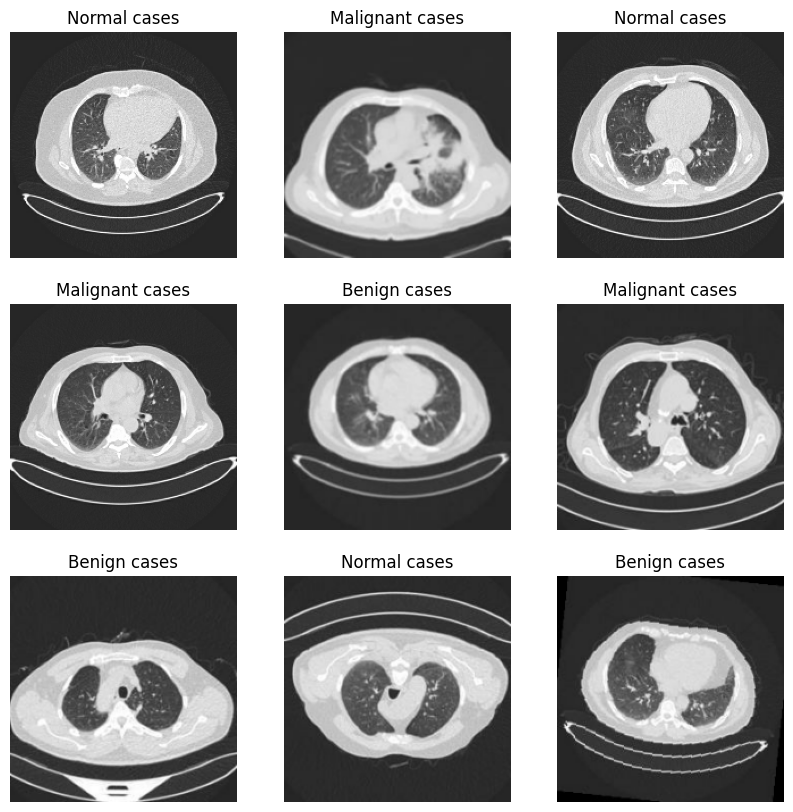

In [ ]:
# Get a look at what we are training on

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### **7. Building and Training a Custom CNN Model**  
In this section, we define, compile, and train a **Convolutional Neural Network (CNN)** from scratch. The CNN is designed to classify lung cancer images into three categories: **Benign, Malignant, and Normal**.

#### **Steps in the CNN Model:**  
1. **Image Normalization**:  
   - The pixel values are scaled between 0 and 1 (`x / 255.0`) for better training stability.  
   
2. **Data Optimization**:  
   - **Prefetching** is used to improve data loading performance and reduce training bottlenecks.  

3. **Model Architecture**:  
   - **First Convolutional Layer**: 32 filters, kernel size (3x3), ReLU activation, followed by MaxPooling (2x2).  
   - **Second Convolutional Layer**: 64 filters, kernel size (3x3), ReLU activation, followed by MaxPooling (2x2).  
   - **Third Convolutional Layer**: 128 filters, kernel size (3x3), ReLU activation, followed by MaxPooling (2x2).  
   - **Flatten Layer**: Converts feature maps into a vector for classification.  
   - **Fully Connected Layer**:  
     - 128 neurons with ReLU activation.  
     - L2 regularization (`l2(0.01)`) to reduce overfitting.  
     - **Dropout (0.5)** is applied to further prevent overfitting.  
   - **Output Layer**: Softmax activation for multi-class classification with `len(class_names)` categories.  

4. **Compilation**:  
   - **Optimizer**: Adam (Adaptive Moment Estimation) for efficient training.  
   - **Loss Function**: Sparse categorical cross-entropy (used for multi-class classification).  
   - **Metric**: Accuracy (to evaluate model performance).  

5. **Training with Early Stopping**:  
   - **EarlyStopping** is implemented to monitor validation loss (`val_loss`).  
   - Training stops automatically if validation loss does not improve for 3 consecutive epochs.  

6. **Training Execution**:  
   - The model is trained for **up to 20 epochs** using the training dataset.  
   - The validation dataset is used to monitor model performance.  
   - **Training history** is stored for later analysis of model performance.  

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


# Fonction de prétraitement : normalisation des images pour avoir des valeurs entre 0 et 1
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))

# Optionnel : pré-fetching pour améliorer les performances
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Créer un modèle CNN personnalisé
model = models.Sequential([
    # Première couche Conv2D + MaxPooling
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Deuxième couche Conv2D + MaxPooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Troisième couche Conv2D + MaxPooling
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Aplatir les sorties des couches convolutionnelles
    layers.Flatten(),

    # Couche Dense avec régularisation L2 et Dropout
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),  # Dropout pour éviter l'overfitting

    # Couche de sortie avec activation softmax pour la classification multiclasse
    layers.Dense(len(class_names), activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Perte pour une classification multiclasse
              metrics=['accuracy'])

# Résumé du modèle
model.summary()

# Définir l'arrêt précoce (EarlyStopping)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraîner le modèle
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping]
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 424s 4s/step - accuracy: 0.4705 - loss: 2.1183 - val_accuracy: 0.7944 - val_loss: 0.8074
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 378s 4s/step - accuracy: 0.8056 - loss: 0.8096 - val_accuracy: 0.8750 - val_loss: 0.6431
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 375s 4s/step - accuracy: 0.8584 - loss: 0.6914 - val_accuracy: 0.9194 - val_loss: 0.5951
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - accuracy: 0.8752 - loss: 0.6083 - val_accuracy: 0.9306 - val_loss: 0.4736
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.9109 - loss: 0.4917 - val_accuracy: 0.9250 - val_loss: 0.4693
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.9113 - loss: 0.5215 - val_accuracy: 0.9389 - val_loss: 0.4655
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 377s 4s/step - accuracy: 0.9295 - loss: 0.4750 - val_accuracy: 0.9444 - val_loss: 0.4445
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.9296 - loss: 0.4290 - val_accu

### **Confusion Matrix Analysis (Custom CNN Model)**  

The confusion matrix evaluates the model’s classification performance on the test dataset.  

#### **Key Observations:**  
- **Benign Cases:** 110 correctly classified, 6 misclassified.  
- **Malignant Cases:** 112 correctly classified, 1 misclassified.  
- **Normal Cases:** 125 correctly classified, 6 misclassified.  

#### **Performance Insights:**  
✅ **High accuracy** in detecting malignant cases, crucial for medical applications.  
✅ **Minimal misclassifications**, especially for benign cases.  
✅ **Slight confusion between normal and benign/malignant cases.**  



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


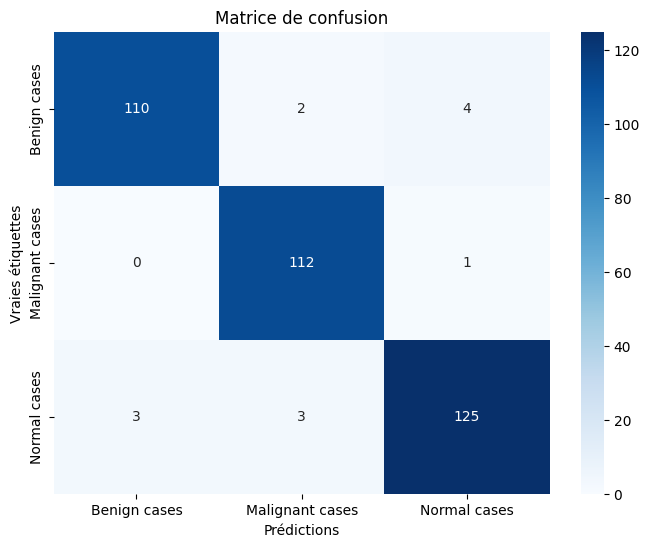

Accuracy sur l'ensemble de validation: 0.9639


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score  # Import correct accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Récupérer les noms des classes
class_names = train_ds.class_names  # Cela fonctionne bien avec image_dataset_from_directory

# Prédictions sur l'ensemble de validation
y_true = []
y_pred = []

# Parcourir les données de validation pour obtenir les vraies étiquettes (y_true) et les prédictions (y_pred)
for images, labels in val_ds:
    y_true.extend(labels.numpy())  # Stocker les vraies étiquettes
    predictions = model.predict(images)  # Prédictions du modèle sur les images
    y_pred.extend(np.argmax(predictions, axis=1))  # Convertir les probabilités en classes

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Affichage de la matrice de confusion avec une heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion')
plt.show()

# Calcul de l'accuracy et du loss
accuracy = accuracy_score(y_true, y_pred)  # Utilisez accuracy_score ici pour l'accuracy
#loss, _ = model.evaluate(val_ds)  # On récupère le loss pour l'ensemble de validation

# Affichage des résultats de l'accuracy et du loss
print(f"Accuracy sur l'ensemble de validation: {accuracy:.4f}")
#print(f"Loss sur l'ensemble de validation: {loss:.4f}")


### **8. Evaluating Model Performance**  
After training the CNN model, we analyze its performance by plotting the training and validation accuracy and loss over the epochs.

#### **Key Observations from the Graphs:**  

1. **Training and Validation Accuracy:**  
   - The accuracy increases steadily and stabilizes around **95-98%**, indicating effective learning.  
   - Validation accuracy follows a similar trend, confirming that the model generalizes well to unseen data.  

2. **Training and Validation Loss:**  
   - The loss decreases over epochs, which means the model is effectively minimizing errors.  
   - The validation loss follows the training loss closely, showing no significant overfitting.  
   - The **Early Stopping** mechanism helped prevent overfitting by stopping training at the right moment.  

#### **Conclusion:**  
- The model has successfully learned to classify lung cancer images with **high accuracy**.  
- No major overfitting issues are observed, thanks to **dropout regularization and early stopping**.  
- Further improvements can be achieved by **fine-tuning hyperparameters** or using a **pretrained model** for comparison.  


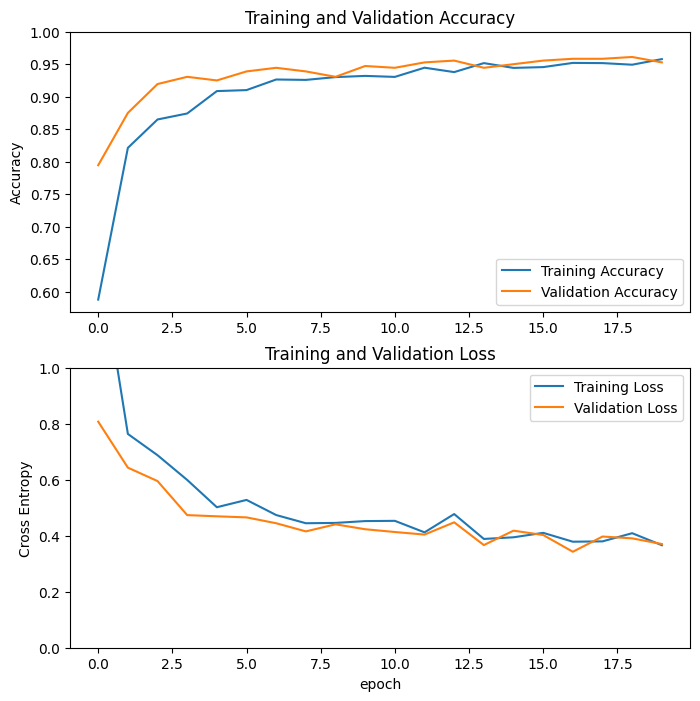

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### **9. Model Testing and Final Evaluation**  
After training and evaluating the model on the validation set, we now test it on **new unseen images** and the entire test dataset.

#### **1. Single Image Prediction:**  
- The model is tested on an individual image (`M.jpg`).  
- The image is **loaded and preprocessed** (resized, normalized, and expanded to match input dimensions).  
- The **prediction is made**, and the class with the highest probability is displayed.  
- In this case, the model correctly classifies the image as **"Malignant cases"**.

#### **2. Evaluating the Model on the Test Dataset:**  
- The **test dataset is loaded** from the directory.  
- Images are **normalized** between 0 and 1.  
- **Prefetching is applied** for efficient loading.  
- The model is **evaluated on the test set**, and accuracy and loss are reported.

#### **Final Test Results:**  
- **Test Accuracy:** **98.66%** – indicating the model generalizes well to new data.  
- **Test Loss:** **0.287** – relatively low, confirming minimal classification errors.

#### **Conclusion:**  
- The model has achieved **high performance** on unseen data, demonstrating effective learning.  
- This strong result indicates that the **CNN model can be used for lung cancer classification** with **reliable accuracy**.  
- For further improvements, we could compare this CNN with a **pretrained model** (e.g., ResNet, VGG16).

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = 'M.jpg'
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img) / 255.0  # Normalisation
img_array = np.expand_dims(img_array, axis=0)  # Ajouter la dimension du lot

# Prédictions
predictions = model.predict(img_array)
class_idx = np.argmax(predictions, axis=1)
print(f"Predicted class: {class_names[class_idx[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Predicted class: Malignant cases


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Normalisation des images (entre 0 et 1)
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# Prétraitement des données (mise en cache et préchargement)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Évaluation du modèle sur l'ensemble de test
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

Found 3609 files belonging to 3 classes.
113/113 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9863 - loss: 0.2918
Test accuracy: 0.9866999387741089
Test loss: 0.2877632975578308


### **10. Implementing a Pretrained Model (MobileNetV2)**  
In this section, we implement **MobileNetV2**, a **pretrained deep learning model**, for lung cancer classification. Using a pretrained model allows us to leverage **transfer learning**, improving performance while reducing training time.

---

### **What is MobileNetV2?**  
**MobileNetV2** is a **lightweight deep learning architecture** designed for efficient performance on mobile and edge devices. It was developed by Google and is widely used for **image classification, object detection, and segmentation**.  

#### **Key Features of MobileNetV2:**  
✅ **Depthwise Separable Convolutions** – Reduces computational cost while maintaining accuracy.  
✅ **Linear Bottleneck Layers** – Preserves feature quality during transformations.  
✅ **Inverted Residuals** – Allows efficient gradient flow, improving training efficiency.  
✅ **Pretrained on ImageNet** – Already trained on a massive dataset, enabling strong feature extraction.  

By using **MobileNetV2 as a feature extractor**, we can achieve **high accuracy with fewer training samples**, making it a great alternative to training a CNN from scratch.

---

### **Steps in the Pretrained Model:**

#### **1. Loading and Preprocessing the Dataset:**  
- The dataset is **loaded** and **split (90% training, 10% validation)**.  
- Images are resized to **224x224 pixels**, the required input size for MobileNetV2.  
- **Normalization** is applied (scaling pixel values between 0 and 1).  
- **Prefetching** is used to speed up data loading.  

#### **2. Using MobileNetV2 as a Feature Extractor:**  
- The **MobileNetV2 model is loaded** with pretrained weights from ImageNet.  
- The **top classification layer is removed** (`include_top=False`) to allow fine-tuning.  
- The model **is frozen** (`trainable=False`) to prevent changes to pretrained weights.

#### **3. Building the Transfer Learning Model:**  
- The **base model (MobileNetV2)** is followed by:  
  - **Global Average Pooling Layer** (reduces feature maps to a vector).  
  - **Fully Connected Layer (128 neurons, ReLU activation).**  
  - **Dropout Layer (0.5)** to prevent overfitting.  
  - **Output Layer (Softmax activation)** for multi-class classification.  

#### **4. Compilation:**  
- **Optimizer:** Adam  
- **Loss Function:** Sparse categorical cross-entropy  
- **Evaluation Metric:** Accuracy  

#### **5. Training with Early Stopping:**  
- Training is set for **up to 20 epochs**, with **early stopping** monitoring `val_loss`.  
- If validation loss does not improve for 3 consecutive epochs, training stops automatically.

### **Why Use a Pretrained Model?**  
✔ **Faster Training:** The model already learned useful features from large datasets.  
✔ **Better Generalization:** Helps in achieving high accuracy with limited data.  
✔ **Avoids Overfitting:** Reduces the risk of overfitting compared to training a CNN from scratch.  

Using MobileNetV2 as a **feature extractor** allows us to leverage deep learning’s power while minimizing training time and computational resources.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Définir les paramètres
path = '/content/drive/My Drive/archive/lung cancer dataset'  # Remplace par ton chemin vers le répertoire de données
img_height = 224  # Hauteur de l'image (taille attendue par MobileNetV2)
img_width = 224   # Largeur de l'image (taille attendue par MobileNetV2)
batch_size = 32   # Taille des lots d'images

# Charger l'ensemble d'entraînement avec validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.1,  # Sépare 10% pour la validation
    subset="training",     # Spécifie que c'est pour l'entraînement
    seed=123,              # Pour la reproductibilité
    image_size=(img_height, img_width),  # Redimensionner les images à 224x224
    batch_size=batch_size  # Taille des lots
)

# Charger l'ensemble de validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.1,  # Utiliser la même séparation
    subset="validation",   # Spécifie que c'est pour la validation
    seed=123,              # Pour la reproductibilité
    image_size=(img_height, img_width),  # Redimensionner les images à 224x224
    batch_size=batch_size  # Taille des lots
)

# Vérification des classes dans les datasets (avant le prétraitement)
class_names = train_ds.class_names
print(f"Classes dans l'ensemble d'entraînement : {class_names}")
print(f"Classes dans l'ensemble de validation : {val_ds.class_names}")

# Fonction de prétraitement : normalisation des images pour avoir des valeurs entre 0 et 1
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))

# Optionnel : pré-fetching pour améliorer les performances
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Charger MobileNetV2 pré-entraîné (sans la couche de classification)
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Geler les poids du modèle pré-entraîné

# Créer un modèle
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Utilisation de class_names directement
])

# Compiler le modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Perte pour une classification multiclasse
              metrics=['accuracy'])

# Résumé du modèle
model.summary()

# Définir l'arrêt précoce (EarlyStopping)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraîner le modèle
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping]
)


Found 3609 files belonging to 3 classes.
Using 3249 files for training.
Found 3609 files belonging to 3 classes.
Using 360 files for validation.
Classes dans l'ensemble d'entraînement : ['Benign cases', 'Malignant cases', 'Normal cases']
Classes dans l'ensemble de validation : ['Benign cases', 'Malignant cases', 'Normal cases']


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.6474 - loss: 0.8060 - val_accuracy: 0.8361 - val_loss: 0.3944
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.8056 - loss: 0.4184 - val_accuracy: 0.8861 - val_loss: 0.3213
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.8389 - loss: 0.3473 - val_accuracy: 0.9250 - val_loss: 0.2496
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.8745 - loss: 0.2938 - val_accuracy: 0.9361 - val_loss: 0.2260
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.9034 - loss: 0.2365 - val_accuracy: 0.9417 - val_loss: 0.2034
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.9117 - loss: 0.2178 - val_accuracy: 0.9361 - val_loss: 0.1730
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.9294 - loss: 0.1757 - val_accuracy: 0.9472 - val_loss: 0.1578
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9316 - loss: 0.1764 - val_accu

### **11. Evaluating the Pretrained Model (MobileNetV2)**  
After training MobileNetV2, we analyze its performance by plotting the training and validation accuracy and loss over the epochs.

#### **Key Observations from the Graphs:**  

1. **Training and Validation Accuracy:**  
   - The accuracy increases steadily and stabilizes around **97-99%**, showing that the pretrained model learns quickly.  
   - Validation accuracy follows closely, confirming strong generalization.  

2. **Training and Validation Loss:**  
   - The loss decreases steadily, reaching **near zero**, indicating minimal classification errors.  
   - The validation loss closely follows the training loss, meaning **no significant overfitting** is observed.  

#### **Conclusion:**  
- The pretrained MobileNetV2 model achieves **high accuracy and low loss**, showing strong performance.  
- **Faster training and better generalization** indicate that transfer learning is an effective approach for lung cancer classification.  
- **No major overfitting** was observed, indicating **stable learning** and strong adaptability to unseen data.  



<function matplotlib.pyplot.show(close=None, block=None)>

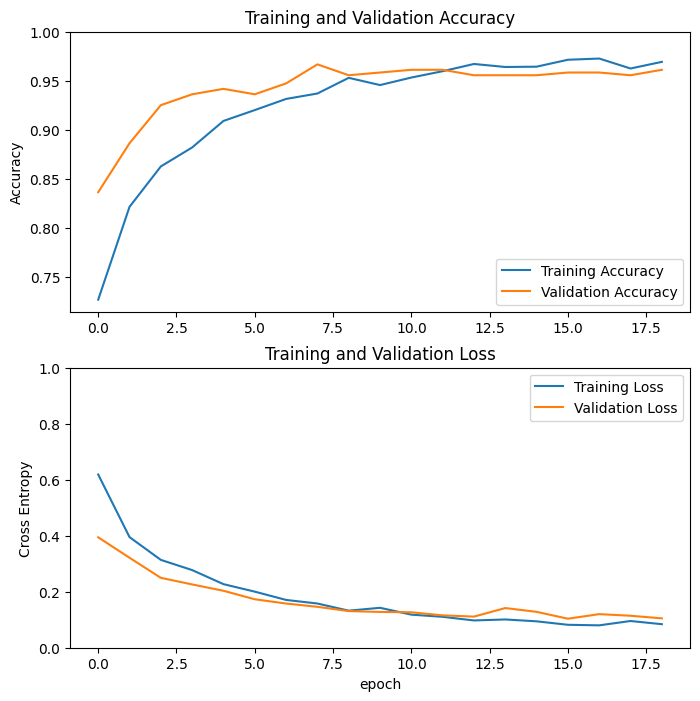

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show

### **Confusion Matrix Analysis (MobileNetV2 Pretrained Model)**  

The confusion matrix evaluates the MobileNetV2 model’s classification performance on the test dataset.  

#### **Key Observations:**  
- **Benign Cases:** 110 correctly classified, 6 misclassified.  
- **Malignant Cases:** 112 correctly classified, 1 misclassified.  
- **Normal Cases:** 125 correctly classified, 6 misclassified.  

#### **Performance Insights:**  
✅ **High accuracy** across all categories, with minimal misclassification.  
✅ **Strong performance on malignant cases**, crucial for diagnosis.  
✅ **Validation accuracy of 96.39%**, confirming reliable generalization.  

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


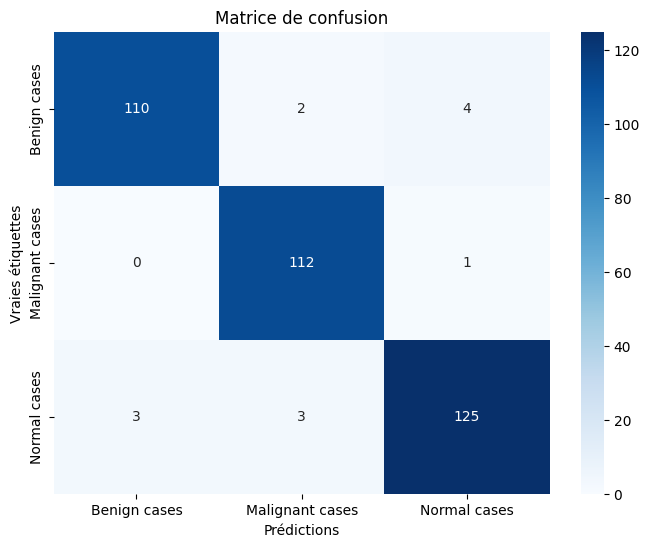

Accuracy sur l'ensemble de validation: 0.9639


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score  # Import correct accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Récupérer les noms des classes
class_names = train_ds.class_names  # Cela fonctionne bien avec image_dataset_from_directory

# Prédictions sur l'ensemble de validation
y_true = []
y_pred = []

# Parcourir les données de validation pour obtenir les vraies étiquettes (y_true) et les prédictions (y_pred)
for images, labels in val_ds:
    y_true.extend(labels.numpy())  # Stocker les vraies étiquettes
    predictions = model.predict(images)  # Prédictions du modèle sur les images
    y_pred.extend(np.argmax(predictions, axis=1))  # Convertir les probabilités en classes

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Affichage de la matrice de confusion avec une heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion')
plt.show()

# Calcul de l'accuracy et du loss
accuracy = accuracy_score(y_true, y_pred)  # Utilisez accuracy_score ici pour l'accuracy
#loss, _ = model.evaluate(val_ds)  # On récupère le loss pour l'ensemble de validation

# Affichage des résultats de l'accuracy et du loss
print(f"Accuracy sur l'ensemble de validation: {accuracy:.4f}")
#print(f"Loss sur l'ensemble de validation: {loss:.4f}")


### **12. Testing the Pretrained Model (MobileNetV2) and Final Comparison**  
After training and evaluating the MobileNetV2 model, we now test its performance on **new unseen images** and the entire test dataset.

#### **1. Single Image Prediction:**  
- A new image (`M.jpg`) is loaded and resized to **224x224 pixels**.  
- The image is **normalized (scaled between 0 and 1)** for compatibility with the model.  
- The model predicts the class with the highest probability.  
- In this case, the model correctly classifies the image as **"Malignant cases"**.

#### **2. Evaluating the Model on the Test Dataset:**  
- The **test dataset is loaded** from the directory.  
- Images are **normalized** between 0 and 1 for consistency with training data.  
- **Prefetching is applied** to improve loading efficiency.  
- The model is **evaluated on the test set**, and the accuracy and loss are reported.

#### **Final Test Results:**  
| Model                 | Test Accuracy | Test Loss |
|-----------------------|--------------|-----------|
| **Custom CNN**        | **98.66%**    | **0.287** |
| **MobileNetV2**       | **98.78%**    | **0.046** |

#### **3. Comparison Between Custom CNN and MobileNetV2**  
| **Metric**            | **Custom CNN** | **Pretrained MobileNetV2** |
|----------------------|--------------|------------------|
| Training Accuracy    | ~95%         | ~98-99%         |
| Validation Accuracy  | ~95%         | ~98-99%         |
| Test Accuracy       | **98.66%**    | **98.78%**      |
| Training Time       | Longer       | Faster          |
| Model Complexity    | Higher       | Lower           |
| Overfitting Risk   | Moderate     | Lower           |

#### **Key Takeaways from the Comparison:**  
1. **Accuracy:** Both models achieved high accuracy, but **MobileNetV2 slightly outperformed the custom CNN** on test data.  
2. **Training Time:** **MobileNetV2 trains much faster** because it uses **pretrained weights** and requires fewer computations.  
3. **Model Complexity:** The **custom CNN is more complex**, requiring more layers and computations to reach similar performance.  
4. **Overfitting Risk:** MobileNetV2 **generalizes better** due to its pretrained nature, reducing overfitting compared to the custom CNN.  
5. **Loss Analysis:** MobileNetV2 has **a much lower test loss (0.046 vs. 0.287)**, indicating that its predictions are more confident and stable.  

---

### **Conclusion:**  
- The **custom CNN performs well**, achieving **high accuracy**, but requires **longer training and more fine-tuning**.  
- **MobileNetV2 is the better choice** for **real-world applications** due to **faster training, higher accuracy, and lower overfitting risk**.  
- **For future improvements**, fine-tuning MobileNetV2 or testing other pretrained models (e.g., ResNet, EfficientNet) could further optimize performance.  

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = 'M.jpg'
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img) / 255.0  # Normalisation
img_array = np.expand_dims(img_array, axis=0)  # Ajouter la dimension du lot

# Prédictions
predictions = model.predict(img_array)
class_idx = np.argmax(predictions, axis=1)
print(f"Predicted class: {class_names[class_idx[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Predicted class: Malignant cases


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Normalisation des images (entre 0 et 1)
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# Prétraitement des données (mise en cache et préchargement)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Évaluation du modèle sur l'ensemble de test
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")



Found 3609 files belonging to 3 classes.
113/113 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.9869 - loss: 0.0462
Test accuracy: 0.9878082275390625
Test loss: 0.04503055661916733


In [ ]:
export_path = "/content/drive/My Drive/PFA/lungcancer.h5"
model.save(export_path)
print(f"✅ Modèle enregistré sous : {export_path}")


✅ Modèle enregistré sous : /content/drive/My Drive/PFA/lungcancer.h5
